# Spotify Playlists EDA

- Kerry Driscoll
- May 25, 2021

**Objective:** What makes a playlist successful?

* promote to other users
* continue promoting to current users/listeners

**Brainstorming**
* success metrics:
  - streams
  - streams30
  - streams30/streams (=% daily streams over 30secs)
  - streams30/dau (=avg. streams per user today)
  - dau
  - wau
  - **mau**
  - mau_previous_months
  - mau_both_months
  - **mau_both_months / mau_previous_months** (=% returned to playlist the following month)
  - monthly_stream30s
  - monthly_owner_stream30s
  - (monthly_stream30s-monthly_owner_stream30s)/monthly_stream30s (=% streams from non-owner)
  - monthly_owner_stream30s / (total monthly_owner_stream30s) (= share of all streams this month)
  - streams30 / (total streams30) (= share of all streams today)
  - skippers / users (=% of users that are more 'at-risk')
  - **monthly_stream30s/mau** (=avg streams per user monthly)
        
* metadata information:
  - *tokens*
  - owner
  - owner_country
  - n_tracks
  - n_local_tracks
  - n_artists
  - n_albums
  - genre_1
  - genre_2
  - genre_3
  - mood_1
  - mood_2
  - mood_3

## Imports

In [1]:
#basic
import os
import sys
import inspect
import time
import datetime
import json

#data
import pandas as pd
import numpy as np
np.seterr(divide='ignore')
import random
import math
from collections import Counter

#stats
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import linalg, sparse, optimize, integrate, stats
from scipy.signal import find_peaks, savgol_filter
from sklearn import preprocessing, linear_model, tree, ensemble, metrics
import scikitplot as skplt
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer,ModelSpecificationParser
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

#visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import to_hex
from matplotlib.ticker import PercentFormatter, AutoMinorLocator, StrMethodFormatter
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected =True)
from IPython.display import Image

#spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2


In [2]:
%env SPOTIPY_CLIENT_ID='f395078429f5419ba232dfd406172ce5'
%env SPOTIPY_CLIENT_SECRET='286d4664f6bd43179f9e9328f7020ad0'
%env SPOTIPY_REDIRECT_URI='http://localhost'

sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

env: SPOTIPY_CLIENT_ID='f395078429f5419ba232dfd406172ce5'
env: SPOTIPY_CLIENT_SECRET='286d4664f6bd43179f9e9328f7020ad0'
env: SPOTIPY_REDIRECT_URI='http://localhost'


In [122]:
credentials = oauth2.SpotifyClientCredentials(
        client_id=os.environ['SPOTIPY_CLIENT_ID'].strip("'"),
        client_secret=os.environ['SPOTIPY_CLIENT_SECRET'].strip("'"))

token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)


/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning:

You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.



In [123]:
lz_uri = 'spotify:artist:36QJpDe2go2KgaRleHCDTp'

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())
results = spotify.artist_top_tracks(lz_uri)

for track in results['tracks'][:5]:
    print('track    : ' + track['name'])
    print('audio    : ' + track['preview_url'])
    print('cover art: ' + track['album']['images'][0]['url'])
    print()

track    : Stairway to Heaven - Remaster
audio    : https://p.scdn.co/mp3-preview/8226164717312bc411f8635580562d67e191a754?cid=f395078429f5419ba232dfd406172ce5
cover art: https://i.scdn.co/image/ab67616d0000b273c8a11e48c91a982d086afc69

track    : Immigrant Song - Remaster
audio    : https://p.scdn.co/mp3-preview/8455599677a13017978dcd3f4b210937f0a16bcb?cid=f395078429f5419ba232dfd406172ce5
cover art: https://i.scdn.co/image/ab67616d0000b27390a50cfe99a4c19ff3cbfbdb

track    : Whole Lotta Love - 1990 Remaster
audio    : https://p.scdn.co/mp3-preview/ce11b19a4d2de9976d7626df0717d0073863909c?cid=f395078429f5419ba232dfd406172ce5
cover art: https://i.scdn.co/image/ab67616d0000b273fc4f17340773c6c3579fea0d

track    : Black Dog - Remaster
audio    : https://p.scdn.co/mp3-preview/9b76619fd9d563a48d38cc90ca00c3008327b52e?cid=f395078429f5419ba232dfd406172ce5
cover art: https://i.scdn.co/image/ab67616d0000b273c8a11e48c91a982d086afc69

track    : Ramble On - 1990 Remaster
audio    : https://p.scdn

## Load Data

In [15]:
df = pd.read_csv('playlist_summary_external.txt', sep='\t')
df.sample(5)

playlist_uri  \
189953  spotify:user:59b79e4913f93e6a508e140660e422c9:...   
348345  spotify:user:677af82dee2efb099859d0e39899b27c:...   
93810   spotify:user:74fca080895441ca7e7ad45dc4b87bf9:...   
317779  spotify:user:ea692cfd6f76beddf9c67de0c971b60d:...   
232198  spotify:user:3da31a8ed090b92a81800d4aa8766524:...   

                                   owner  streams  stream30s  dau  wau  mau  \
189953  59b79e4913f93e6a508e140660e422c9       77         76    1    4   16   
348345  677af82dee2efb099859d0e39899b27c        0          0    0    1    2   
93810   74fca080895441ca7e7ad45dc4b87bf9       18         18    1    1    2   
317779  ea692cfd6f76beddf9c67de0c971b60d        0          0    0    1    2   
232198  3da31a8ed090b92a81800d4aa8766524        0          0    0    1    2   

        mau_previous_month  mau_both_months  users     ...      n_albums  \
189953                  11                2     28     ...             1   
348345                   2                1      3     ...            18   
93810                    1                1      5     ...            17   
317779                   1                1      3     ...            33   
232198                   1                1      2     ...            11   

       monthly_stream30s  monthly_owner_stream30s  \
189953               727                      495   
348345                41                       40   
93810                 47                       25   
317779                74                       61   
232198                17                       15   

                                    tokens    genre_1         genre_2  \
189953      ["keith", "green", "ministry"]  Religious               -   
348345                   ["tony", "danza"]        Rap     Electronica   
93810   ["michael", "jackson", "thriller"]        R&B   Dance & House   
317779                            ["fall"]        Rap             R&B   
232198                 ["guru", "purnima"]    New Age  Country & Folk   

            genre_3      mood_1      mood_2      mood_3  
189953            -      Upbeat      Gritty       Rowdy  
348345          R&B     Defiant  Aggressive     Excited  
93810           Pop  Energizing     Excited       Fiery  
317779   Indie Rock     Defiant     Sensual  Energizing  
232198  Traditional    Peaceful  Melancholy      Somber  

[5 rows x 25 columns]

In [16]:
for month in ['january', 'february','march',
             'april','may','june',
             'july','august','september',
             'october','november','december']:
    
    num_playlists = df['tokens'].apply(lambda x: month in x).sum()
    num_streams_today = df[df['tokens'].apply(lambda x: month in x)]['stream30s'].sum()
    num_streams_month = df[df['tokens'].apply(lambda x: month in x)]['monthly_stream30s'].sum()
    
    print(month, num_playlists, num_streams_today, num_streams_month)

january 22 98 3389
february 22 33 903
march 112 585 19660
april 121 478 11269
may 606 5694 176029
june 232 718 19465
july 487 1274 45314
august 853 2841 115112
september 1646 9385 453301
october 267 2051 38049
november 43 523 12407
december 49 198 4241


In [17]:
key_metrics = [col for col in df.columns if (df[col].dtype!='O') & ('n_' not in col)]
df[key_metrics].describe(percentiles=[i/10 for i in range(10)]).T

count         mean            std  min   0%   10%  \
streams                  403366.0    71.013752    6492.013742  0.0  0.0   0.0   
stream30s                403366.0    42.833333    3772.412203  0.0  0.0   0.0   
dau                      403366.0     4.418265     358.855685  0.0  0.0   0.0   
wau                      403366.0    21.784446    1614.650805  0.0  0.0   0.0   
mau                      403366.0    66.142895    4732.580187  2.0  2.0   2.0   
mau_previous_month       403366.0    58.190088    3827.248092  0.0  0.0   1.0   
mau_both_months          403366.0    12.937065    1240.912979  0.0  0.0   0.0   
users                    403366.0   149.308467    9247.483569  2.0  2.0   2.0   
skippers                 403366.0     2.827749     205.059728  0.0  0.0   0.0   
monthly_stream30s        403366.0  1260.488586  106246.292506  2.0  2.0  13.0   
monthly_owner_stream30s  403366.0    93.556621     226.250189  0.0  0.0   1.0   

                          20%   30%   40%   50%    60%    70%    80%    90%  \
streams                   0.0   0.0   0.0   1.0    2.0    6.0   12.0   28.0   
stream30s                 0.0   0.0   0.0   0.0    1.0    3.0    7.0   17.0   
dau                       0.0   0.0   0.0   0.0    1.0    1.0    1.0    1.0   
wau                       1.0   1.0   1.0   1.0    1.0    2.0    2.0    3.0   
mau                       2.0   2.0   2.0   2.0    2.0    3.0    4.0    9.0   
mau_previous_month        1.0   1.0   1.0   2.0    2.0    3.0    4.0    9.0   
mau_both_months           1.0   1.0   1.0   1.0    1.0    1.0    2.0    2.0   
users                     2.0   2.0   3.0   3.0    4.0    6.0   10.0   22.0   
skippers                  0.0   0.0   0.0   0.0    0.0    0.0    1.0    1.0   
monthly_stream30s        24.0  38.0  55.0  79.0  111.0  159.0  240.0  432.0   
monthly_owner_stream30s   4.0   9.0  18.0  30.0   48.0   76.0  124.0  231.0   

                                max  
streams                   2629715.0  
stream30s                 1513237.0  
dau                        152929.0  
wau                        669966.0  
mau                       1944150.0  
mau_previous_month        1478684.0  
mau_both_months            578391.0  
users                     3455406.0  
skippers                    86162.0  
monthly_stream30s        42497334.0  
monthly_owner_stream30s     25904.0

### Create KPIs

In [18]:
#percent 'complete' stream
df['perc_stream30s'] = (df['stream30s']/df['streams']).fillna(0)

#avg streams per user
df['stream_per_user_daily'] = (df['stream30s']/df['dau']).fillna(0)
df['stream_per_user_monthly'] = (df['monthly_stream30s']/df['mau']).fillna(0)

#return to playlist following month (continuous)
df['month_to_month_funnel'] = (df['mau_both_months'] / df['mau_previous_month']).fillna(0)
df['monthly_non_owner_stream30s'] = df['monthly_stream30s']-df['monthly_owner_stream30s']
df['perc_non_owner_monthly'] = df['monthly_non_owner_stream30s'] / df['monthly_stream30s']

#share of all streams
df['share_monthly_streams30s'] = df['monthly_stream30s']/(df['monthly_stream30s'].sum())
df['share_daily_streams30s'] = df['stream30s']/(df['stream30s'].sum())

#share skippers
df['perc_skippers'] = (df['skippers']/df['users']).fillna(0)

df.sample(5)

playlist_uri  \
367969  spotify:user:860bd86c3c1a5fe61b7fb8c0e675d901:...   
314989  spotify:user:47a56259c91927d45a8d8006550a2d45:...   
186476  spotify:user:9503dc5605bbbb225159fc9c703cde4e:...   
183040  spotify:user:ed9c6b216ef257fb2ee868f84e7c2368:...   
236706  spotify:user:e0595a9d85ecf4eeb87b6eedc91a3872:...   

                                   owner  streams  stream30s  dau  wau  mau  \
367969  860bd86c3c1a5fe61b7fb8c0e675d901       48          4    1    1    2   
314989  47a56259c91927d45a8d8006550a2d45        1          0    0    1    7   
186476  9503dc5605bbbb225159fc9c703cde4e       11         10    1    1    4   
183040  ed9c6b216ef257fb2ee868f84e7c2368        0          0    0    1    2   
236706  e0595a9d85ecf4eeb87b6eedc91a3872       21         19    1    1    2   

        mau_previous_month  mau_both_months  users      ...         mood_3  \
367969                   2                2      2      ...        Excited   
314989                   8                2     13      ...       Peaceful   
186476                   4                1      9      ...        Defiant   
183040                   2                1      2      ...        Excited   
236706                   1                1      2      ...       Brooding   

       perc_stream30s  stream_per_user_daily  stream_per_user_monthly  \
367969       0.083333                    4.0               242.500000   
314989       0.000000                    0.0                 3.714286   
186476       0.909091                   10.0                 7.000000   
183040       0.000000                    0.0                10.500000   
236706       0.904762                   19.0                47.500000   

        month_to_month_funnel  monthly_non_owner_stream30s  \
367969                   1.00                           44   
314989                   0.25                           26   
186476                   0.25                           24   
183040                   0.50                            6   
236706                   1.00                           11   

        perc_non_owner_monthly  share_monthly_streams30s  \
367969                0.090722              9.539015e-07   
314989                1.000000              5.113699e-08   
186476                0.857143              5.507060e-08   
183040                0.285714              4.130295e-08   
236706                0.115789              1.868467e-07   

       share_daily_streams30s perc_skippers  
367969           2.315148e-07      0.500000  
314989           0.000000e+00      0.076923  
186476           5.787871e-07      0.000000  
183040           0.000000e+00      0.000000  
236706           1.099696e-06      0.000000  

[5 rows x 34 columns]

### Limit Scope

In [19]:
df.groupby(['owner']).agg({'playlist_uri':'count'
                           ,'mau':'sum'
                          })\
    .sort_values(by='mau', ascending=False).head(10)

playlist_uri       mau
owner                                                   
spotify                                    399  20691509
e60d19313a8df36c7e6cf59e259e0d66            31    293857
a19ebea5b5c28f3eff7f45167f7f3b1c             9    236766
6987037f34b5cee787a1a5e8de9b2689            48    182490
cb305f632c793f009882083e9e75f5b0            33    104972
9fe04aabaa2534b13e89a9d31ac3e77d             5     64207
5ccffa50978387bb63f3c4754ad7fe53             2     63421
0dd8a0b6d017c880d3e33a8ac4d90793             1     53098
aa7143ee2164d5883de72ec7368d48a6             5     52672
2ed777bdb3b70101b69430fedc051d90             9     48227

In [20]:
df['playlist_owner_type'] = df['owner'].apply(lambda x: x if x=='spotify' else 'individual user')
df.sample(5)

playlist_uri  \
366296  spotify:user:39e3ba2a06b092d11a7e5ccd7c48f337:...   
152395  spotify:user:3511ccd75cd12fcde90ee2fc947130c2:...   
196355  spotify:user:3b16b5eaa3652ef9b2932d6d6ec7e487:...   
80554   spotify:user:spotify:playlist:1oTVoAzl0uw6tcmP...   
48315   spotify:user:2c6e3639094ef41e00a475d704c1416a:...   

                                   owner  streams  stream30s  dau   wau   mau  \
366296  39e3ba2a06b092d11a7e5ccd7c48f337        4          4    1     2     4   
152395  3511ccd75cd12fcde90ee2fc947130c2        3          3    1     2     3   
196355  3b16b5eaa3652ef9b2932d6d6ec7e487        4          2    1     1     2   
80554                            spotify     4742       4008  365  1704  4827   
48315   2c6e3639094ef41e00a475d704c1416a       26          7    1     1     3   

        mau_previous_month  mau_both_months  users         ...          \
366296                   3                1     10         ...           
152395                   2                2      3         ...           
196355                   3                1      5         ...           
80554                 3660              284  13863         ...           
48315                    2                2      3         ...           

        perc_stream30s stream_per_user_daily  stream_per_user_monthly  \
366296        1.000000              4.000000                 8.500000   
152395        1.000000              3.000000                49.000000   
196355        0.500000              2.000000                25.500000   
80554         0.845213             10.980822                14.782681   
48315         0.269231              7.000000               100.666667   

        month_to_month_funnel  monthly_non_owner_stream30s  \
366296               0.333333                           27   
152395               1.000000                           91   
196355               0.333333                           38   
80554                0.077596                        71356   
48315                1.000000                           13   

        perc_non_owner_monthly  share_monthly_streams30s  \
366296                0.794118              6.687145e-08   
152395                0.619048              2.891207e-07   
196355                0.745098              1.003072e-07   
80554                 1.000000              1.403435e-04   
48315                 0.043046              5.939758e-07   

        share_daily_streams30s perc_skippers playlist_owner_type  
366296            2.315148e-07      0.000000     individual user  
152395            1.736361e-07      0.000000     individual user  
196355            1.157574e-07      0.000000     individual user  
80554             2.319779e-04      0.024598             spotify  
48315             4.051510e-07      0.333333     individual user  

[5 rows x 35 columns]

In [21]:
df.groupby(['playlist_owner_type'])['mau'].describe(percentiles=[i/100 for i in range(100)])#.T

count          mean            std  min   0%    1%  \
playlist_owner_type                                                          
individual user      402967.0     14.860487     504.704081  2.0  2.0   2.0   
spotify                 399.0  51858.418546  140532.850014  2.0  2.0  23.6   

                        2%      3%     4%     5%    ...            91%  \
playlist_owner_type                                 ...                  
individual user       2.00    2.00    2.0    2.0    ...          11.00   
spotify              81.88  154.74  213.0  251.4    ...      136584.62   

                           92%        93%        94%       95%        96%  \
playlist_owner_type                                                         
individual user          12.00      14.00      17.00      21.0      27.00   
spotify              152539.56  182336.16  203379.28  230516.7  252000.56   

                           97%        98%       99%        max  
playlist_owner_type                                             
individual user          38.00      60.00     128.0   206756.0  
spotify              265104.74  286135.04  354017.3  1944150.0  

[2 rows x 105 columns]

In [22]:
fig = px.strip(df[df['mau']>=128]
                , y="mau"
                , x="playlist_owner_type"
                , color="genre_1"
                , stripmode="overlay"
                #, points='all'
                #, box=True
                , hover_name='tokens'
                , title="Playlist Monthly Active Users"
               )
fig.show()

## Factor Analysis

In [26]:
def get_dummies_with_multiple_columns(prefix, dataframe):
    relevant_columns = [col for col in dataframe.columns if prefix in col]
    
    overall_dummies = pd.DataFrame(index=dataframe.index
                                   , columns=pd.get_dummies(dataframe[relevant_columns[0]], prefix=prefix.title()).columns)
    
    for col in relevant_columns:
        new_dummies = pd.get_dummies(dataframe[col], prefix=prefix.title())
        overall_dummies = overall_dummies.add(new_dummies, fill_value=0)
        overall_dummies = overall_dummies.astype(int)
        
    return overall_dummies
    

In [27]:
genres = get_dummies_with_multiple_columns('genre', df)
moods = get_dummies_with_multiple_columns('mood', df)

In [28]:
df = df.merge(genres, left_index=True, right_index=True).merge(moods, left_index=True, right_index=True)
df.sample(5)

playlist_uri  \
184774  spotify:user:2351671dca269c7eb4b3dd22e7c251e5:...   
148747  spotify:user:33ce15297f1821f1ca73cfcf67b1e35b:...   
84091   spotify:user:66330ac140841b01459ff5e3ad410642:...   
393566  spotify:user:47a0223842f4f767c2c1d76c27d957dd:...   
262425  spotify:user:1cd18590000fad8b4317ac4934778f7f:...   

                                   owner  streams  stream30s  dau  wau  mau  \
184774  2351671dca269c7eb4b3dd22e7c251e5        0          0    0    1    2   
148747  33ce15297f1821f1ca73cfcf67b1e35b        1          1    1    3    8   
84091   66330ac140841b01459ff5e3ad410642        5          4    1    1    3   
393566  47a0223842f4f767c2c1d76c27d957dd       18          4    1    6   18   
262425  1cd18590000fad8b4317ac4934778f7f       14         14    1    1    3   

        mau_previous_month  mau_both_months  users      ...       \
184774                   2                1      4      ...        
148747                   7                3     20      ...        
84091                    4                3      4      ...        
393566                  19                2     45      ...        
262425                   4                1      8      ...        

        Mood_Sensual Mood_Sentimental  Mood_Serious  Mood_Somber  \
184774             0                0             0            0   
148747             1                0             0            0   
84091              0                0             0            0   
393566             0                0             0            0   
262425             0                0             0            0   

        Mood_Sophisticated  Mood_Stirring  Mood_Tender  Mood_Upbeat  \
184774                   0              0            0            0   
148747                   0              0            0            0   
84091                    0              0            0            0   
393566                   0              0            0            0   
262425                   0              0            0            0   

       Mood_Urgent Mood_Yearning  
184774           0             0  
148747           0             0  
84091            0             0  
393566           0             0  
262425           0             1  

[5 rows x 88 columns]

In [29]:
kmo_all,kmo_model=calculate_kmo(df[[col for col in df.columns if 'Mood' in col]])
kmo_model

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/factor_analyzer/utils.py:248: UserWarning:

The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.



0.6449681395993513

### Mood + Genre Factors

#### Build

In [31]:
fa = FactorAnalyzer()
fa.fit(df[[col for col in df.columns if ('Mood' in col) | ('Genre' in col)]], 25)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([ 4.25011542e+00,  3.48888044e+00,  2.68047472e+00,  2.16236930e+00,
        2.02506644e+00,  1.85496628e+00,  1.57017609e+00,  1.48053810e+00,
        1.41511001e+00,  1.31712892e+00,  1.22586360e+00,  1.20279620e+00,
        1.17234488e+00,  1.13523762e+00,  1.08502010e+00,  1.03671534e+00,
        1.01413435e+00,  1.00129699e+00,  9.68572143e-01,  9.52888869e-01,
        9.11680026e-01,  9.00776105e-01,  8.85085989e-01,  8.57310912e-01,
        8.49775077e-01,  8.10717108e-01,  7.79741578e-01,  7.65293159e-01,
        7.52865777e-01,  7.42379677e-01,  6.98055871e-01,  6.89927349e-01,
        6.82803132e-01,  6.49634274e-01,  6.34028732e-01,  6.21877889e-01,
        6.13926760e-01,  5.97877757e-01,  5.86381787e-01,  5.72775425e-01,
        5.65761854e-01,  5.49476828e-01,  5.48921789e-01,  5.26120609e-01,
        5.12632472e-01,  5.01800417e-01,  4.86107597e-01,  4.74698292e-01,
        4.32942000e-01,  4.13383248e-01,  3.45544685e-01,  1.77763639e-15,
       -6.04201686e-16])

Text(18.5, 1.4685721427834104, '18')

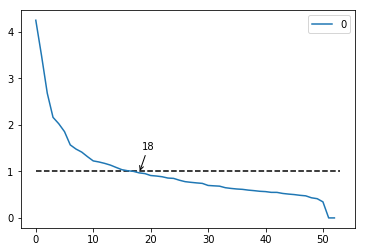

In [32]:
pd.DataFrame(ev).plot(label='eigenvalues')
plt.hlines(1, xmin=0, xmax=len(ev), linestyle='--', label='scree')
plt.annotate("{}".format(sum(ev>1))
             , xy=(sum(ev>1), ev[sum(ev>1)])
             , xytext=(sum(ev>1)+0.5, ev[sum(ev>1)]+0.5)
             , arrowprops=dict(arrowstyle="->")
            )

In [33]:
fa = FactorAnalyzer(rotation="promax", n_factors=18)
fa.fit(df[[col for col in df.columns if ('Mood' in col) | ('Genre' in col)]])
#fa.loadings

load = pd.DataFrame(fa.loadings_
                    ,index=[col for col in df.columns if ('Mood' in col) | ('Genre' in col)]
                   ,columns=['Upbeat Indie Rock/Pop','Top Pop & Dance','Mixed Pop & Rock Throwbacks','Latin'
,'Metal/Punk','Non-Lyrical Studying & Meditation','Classical & Scores'
,'Nulls','Country','Laid Back Hip Hop'
,'Mixed Bag','Musical/Soundtrack'
,'Island Reggae & Smooth Soul','Church-y','Folksy Acoustic','Slower Jazz'
,'International','Spoken & High Tempo Workout'
]
                   )\
    #.sort_values(by=14, ascending=False)

cm = sns.light_palette("green", as_cmap=True)

s = load.style.background_gradient(cmap=cm)
#s.to_excel('playlist_factor_loadings.xlsx')
s

#### Apply

In [37]:
def build_factors(factor_specs, dataframe):
    for factor in factor_specs.columns:
        factor_dict = factor_specs[factor].to_dict()
        
        df["Factor_{}".format(factor.replace(' ','_'))] = df[list(factor_dict.keys())].values.dot(np.array(list(factor_dict.values())))
        
    return df

In [59]:
df2 = build_factors(load, df)
df2['Dominant Factor'] = df2[[col for col in df2.columns if 'Factor_' in col]].idxmax(axis=1)
df2['Dominant Type'] = df2['Dominant Factor'].apply(lambda x: x.replace('Factor_', '').replace('_',' '))
cat_order = list(df2.groupby(['Dominant Type'])['mau']\
     .sum().sort_values(ascending=False).index)
df2.sample(5)

playlist_uri  \
369995  spotify:user:6104721e60ee0245dcb945613410f240:...   
255486  spotify:user:4dd03365942392cbf602f1a73f97e8b2:...   
218343  spotify:user:acab143d1c7052c7b68f6040edda6884:...   
207647  spotify:user:7d0329dc1d320693727f21f8fbd3edab:...   
131397  spotify:user:48476d05af83f6494bb7bff0e6670181:...   

                                   owner  streams  stream30s  dau  wau  mau  \
369995  6104721e60ee0245dcb945613410f240        0          0    0    1    3   
255486  4dd03365942392cbf602f1a73f97e8b2       11         10    1    1    2   
218343  acab143d1c7052c7b68f6040edda6884        4          3    1    1    2   
207647  7d0329dc1d320693727f21f8fbd3edab        1          1    1    1    3   
131397  48476d05af83f6494bb7bff0e6670181       12          6    1    1    2   

        mau_previous_month  mau_both_months  users          ...            \
369995                   1                1      6          ...             
255486                   0                0      2          ...             
218343                   2                1      4          ...             
207647                  15                1     28          ...             
131397                   3                2      4          ...             

        Factor_Mixed_Bag Factor_Musical/Soundtrack  \
369995          0.490912                  0.675589   
255486         -0.383459                 -0.248313   
218343          0.353889                 -0.131841   
207647         -0.560780                  0.726297   
131397          0.271467                 -0.128285   

        Factor_Island_Reggae_&_Smooth_Soul  Factor_Church-y  \
369995                           -0.235812         0.309106   
255486                           -0.120577         0.093357   
218343                           -0.039214        -0.012803   
207647                           -0.282206        -0.017469   
131397                           -0.036738        -0.272119   

        Factor_Folksy_Acoustic  Factor_Slower_Jazz  Factor_International  \
369995               -0.314185           -0.164443             -0.046019   
255486               -0.163930           -0.029618             -0.175119   
218343               -0.052265           -0.168914             -0.218232   
207647               -0.139854           -0.095902              0.038113   
131397               -0.135360           -0.194328             -0.118994   

        Factor_Spoken_&_High_Tempo_Workout               Dominant Factor  \
369995                           -0.112817             Factor_Metal/Punk   
255486                            0.015571                  Factor_Nulls   
218343                           -0.087893  Factor_Upbeat_Indie_Rock/Pop   
207647                           -0.094693     Factor_Musical/Soundtrack   
131397                           -0.082889  Factor_Upbeat_Indie_Rock/Pop   

                Dominant Type  
369995             Metal/Punk  
255486                  Nulls  
218343  Upbeat Indie Rock/Pop  
207647     Musical/Soundtrack  
131397  Upbeat Indie Rock/Pop  

[5 rows x 108 columns]

In [60]:
share_df = df2.groupby(['Dominant Type']).agg({'playlist_uri':'nunique'
                                      ,'n_tracks':'sum'
                                      ,'monthly_stream30s':'sum'
                                     }).apply(lambda x: x/x.sum())\
                                .sort_values('playlist_uri', ascending=False)\
                                #.assign(ratio=monthly_stream30s/playlist_uri)

share_df = share_df.assign(ratio=share_df['monthly_stream30s']/share_df['playlist_uri'])\
    .assign(ratio=share_df['monthly_stream30s']/share_df['n_tracks'])\
    #.sort_values(by='ratio2', ascending=False)
share_df

playlist_uri  n_tracks  monthly_stream30s  \
Dominant Type                                                                  
Top Pop & Dance                        0.264127  0.271012           0.290932   
Upbeat Indie Rock/Pop                  0.216144  0.230548           0.196635   
Mixed Pop & Rock Throwbacks            0.079868  0.079553           0.058278   
Metal/Punk                             0.071084  0.114943           0.042951   
Nulls                                  0.066240  0.013884           0.014930   
Mixed Bag                              0.061465  0.064638           0.161375   
Country                                0.058094  0.063580           0.073468   
Latin                                  0.032534  0.030274           0.015710   
Folksy Acoustic                        0.030774  0.023627           0.067667   
Church-y                               0.026879  0.019115           0.007975   
Island Reggae & Smooth Soul            0.023594  0.023921           0.006099   
Musical/Soundtrack                     0.016154  0.014301           0.007923   
Non-Lyrical Studying & Meditation      0.014567  0.010964           0.021184   
Classical & Scores                     0.013477  0.014196           0.016657   
Slower Jazz                            0.007266  0.008374           0.013353   
Spoken & High Tempo Workout            0.006666  0.008279           0.002055   
International                          0.006106  0.004238           0.001402   
Laid Back Hip Hop                      0.004961  0.004552           0.001406   

                                      ratio  
Dominant Type                                
Top Pop & Dance                    1.073503  
Upbeat Indie Rock/Pop              0.852901  
Mixed Pop & Rock Throwbacks        0.732565  
Metal/Punk                         0.373671  
Nulls                              1.075349  
Mixed Bag                          2.496583  
Country                            1.155519  
Latin                              0.518951  
Folksy Acoustic                    2.863934  
Church-y                           0.417230  
Island Reggae & Smooth Soul        0.254954  
Musical/Soundtrack                 0.554026  
Non-Lyrical Studying & Meditation  1.932086  
Classical & Scores                 1.173343  
Slower Jazz                        1.594636  
Spoken & High Tempo Workout        0.248225  
International                      0.330937  
Laid Back Hip Hop                  0.308781

In [61]:
flat_share = pd.melt(share_df.sort_values(by='monthly_stream30s', ascending=False).reset_index()
                     , id_vars='Dominant Type')\
        .rename(columns={'variable':'Metric', 'value':'% Share'})\
        .replace('playlist_uri','# Playlists')\
        .replace('monthly_stream30s', '# Monthly Streams')\
        .replace('n_tracks','# Tracks')
flat_share[flat_share['Metric']!='ratio']

Dominant Type             Metric   % Share
0                     Top Pop & Dance        # Playlists  0.264127
1               Upbeat Indie Rock/Pop        # Playlists  0.216144
2                           Mixed Bag        # Playlists  0.061465
3                             Country        # Playlists  0.058094
4                     Folksy Acoustic        # Playlists  0.030774
5         Mixed Pop & Rock Throwbacks        # Playlists  0.079868
6                          Metal/Punk        # Playlists  0.071084
7   Non-Lyrical Studying & Meditation        # Playlists  0.014567
8                  Classical & Scores        # Playlists  0.013477
9                               Latin        # Playlists  0.032534
10                              Nulls        # Playlists  0.066240
11                        Slower Jazz        # Playlists  0.007266
12                           Church-y        # Playlists  0.026879
13                 Musical/Soundtrack        # Playlists  0.016154
14        Island Reggae & Smooth Soul        # Playlists  0.023594
15        Spoken & High Tempo Workout        # Playlists  0.006666
16                  Laid Back Hip Hop        # Playlists  0.004961
17                      International        # Playlists  0.006106
18                    Top Pop & Dance           # Tracks  0.271012
19              Upbeat Indie Rock/Pop           # Tracks  0.230548
20                          Mixed Bag           # Tracks  0.064638
21                            Country           # Tracks  0.063580
22                    Folksy Acoustic           # Tracks  0.023627
23        Mixed Pop & Rock Throwbacks           # Tracks  0.079553
24                         Metal/Punk           # Tracks  0.114943
25  Non-Lyrical Studying & Meditation           # Tracks  0.010964
26                 Classical & Scores           # Tracks  0.014196
27                              Latin           # Tracks  0.030274
28                              Nulls           # Tracks  0.013884
29                        Slower Jazz           # Tracks  0.008374
30                           Church-y           # Tracks  0.019115
31                 Musical/Soundtrack           # Tracks  0.014301
32        Island Reggae & Smooth Soul           # Tracks  0.023921
33        Spoken & High Tempo Workout           # Tracks  0.008279
34                  Laid Back Hip Hop           # Tracks  0.004552
35                      International           # Tracks  0.004238
36                    Top Pop & Dance  # Monthly Streams  0.290932
37              Upbeat Indie Rock/Pop  # Monthly Streams  0.196635
38                          Mixed Bag  # Monthly Streams  0.161375
39                            Country  # Monthly Streams  0.073468
40                    Folksy Acoustic  # Monthly Streams  0.067667
41        Mixed Pop & Rock Throwbacks  # Monthly Streams  0.058278
42                         Metal/Punk  # Monthly Streams  0.042951
43  Non-Lyrical Studying & Meditation  # Monthly Streams  0.021184
44                 Classical & Scores  # Monthly Streams  0.016657
45                              Latin  # Monthly Streams  0.015710
46                              Nulls  # Monthly Streams  0.014930
47                        Slower Jazz  # Monthly Streams  0.013353
48                           Church-y  # Monthly Streams  0.007975
49                 Musical/Soundtrack  # Monthly Streams  0.007923
50        Island Reggae & Smooth Soul  # Monthly Streams  0.006099
51        Spoken & High Tempo Workout  # Monthly Streams  0.002055
52                  Laid Back Hip Hop  # Monthly Streams  0.001406
53                      International  # Monthly Streams  0.001402

### Evaluate

In [62]:
fig = px.bar(flat_share[flat_share['Metric']!='ratio']
             , x="Metric", y="% Share"
             , color="Dominant Type"
             #, orientation = 'v'
             , title="KPI Share by Playlist Type")
fig.show()

In [63]:
fig = px.strip(df2[df2['mau']>=128]
                , y="mau"
                , x="playlist_owner_type"
                , color="Dominant Type"
                , category_orders={"playlist_owner_type":['spotify', 'individual user'],
                                   "Dominant Type": cat_order}
                , stripmode="overlay"
                #, points='all'
                #, box=True
                , hover_name='tokens'
                , title="Playlist Monthly Active Users"
               )
fig.show()

In [64]:
fig = px.strip(df2[df2['mau']>=128]
                , y="stream_per_user_monthly"
                , x="playlist_owner_type"
                , color="Dominant Type"
                , category_orders={"playlist_owner_type":['spotify', 'individual user'],
                                   "Dominant Type": cat_order}
                , stripmode="overlay"
                #, points='all'
                #, box=True
                , hover_name='tokens'
                , title="Playlist Streams Per Active (Monthly)"
               )
fig.show()

In [65]:
df.groupby(['playlist_owner_type'])['stream_per_user_monthly'].describe(percentiles=[i/100 for i in range(100)])#.T

count       mean        std  min   0%        1%  \
playlist_owner_type                                                       
individual user      402967.0  50.439028  97.682358  1.0  1.0  1.500000   
spotify                 399.0  12.594347   5.189703  1.0  1.0  3.752501   

                           2%       3%        4%        5%     ...       \
playlist_owner_type                                            ...        
individual user      2.000000  2.50000  2.800000  3.000000     ...        
spotify              4.036056  4.85725  5.165774  5.370172     ...        

                           91%         92%         93%         94%  \
playlist_owner_type                                                  
individual user      124.50000  134.500000  146.000000  160.000000   
spotify               19.64059   20.309602   20.734302   21.431539   

                            95%         96%         97%         98%  \
playlist_owner_type                                                   
individual user      176.666667  199.500000  230.000000  281.000000   
spotify               21.802175   22.548142   23.401635   26.748625   

                            99%          max  
playlist_owner_type                           
individual user      385.622667  12477.37500  
spotify               27.593109     35.52031  

[2 rows x 105 columns]

In [66]:
df2[df2['mau']>=128].groupby(['playlist_owner_type'])['stream_per_user_monthly'].describe(percentiles=[i/4 for i in range(4)])#.T

count       mean        std       min        0%  \
playlist_owner_type                                                     
individual user      4039.0  17.467442  11.494034  1.619048  1.619048   
spotify               389.0  12.678427   5.148813  2.559636  2.559636   

                          25%        50%        75%         max  
playlist_owner_type                                              
individual user      9.829545  15.163885  22.076578  138.311523  
spotify              9.203540  12.136930  15.030419   35.520310

In [67]:
fig = px.strip(df2[(df2['mau']>=128) & (df2['mau_previous_month']>2)]
                , y="month_to_month_funnel"
                , x="playlist_owner_type"
                , color="Dominant Type"
                , category_orders={"playlist_owner_type":['spotify', 'individual user'],
                                   "Dominant Type": cat_order}
                , stripmode="overlay"
                #, points='all'
                #, box=True
                , hover_name='tokens'
                , title="Playlist Month-to-Month Retention"
               )
fig.show()

In [68]:
df2[(df2['mau']>=128) & 
    (df2['mau_previous_month']>2)]\
    .groupby(['playlist_owner_type'])['month_to_month_funnel'].describe(percentiles=[i/100 for i in range(100)])#.T

count      mean       std       min        0%        1%  \
playlist_owner_type                                                             
individual user      3932.0  0.160331  0.092936  0.006098  0.006098  0.028140   
spotify               366.0  0.142012  0.069540  0.011344  0.011344  0.025494   

                           2%        3%        4%        5%    ...     \
playlist_owner_type                                            ...      
individual user      0.033890  0.039604  0.043216  0.046053    ...      
spotify              0.041427  0.048186  0.051663  0.054767    ...      

                          91%       92%       93%       94%       95%  \
playlist_owner_type                                                     
individual user      0.296902  0.304965  0.315143  0.333333  0.348276   
spotify              0.231489  0.234338  0.243864  0.251866  0.261325   

                          96%       97%       98%       99%       max  
playlist_owner_type                                                    
individual user      0.365428  0.381977  0.420519  0.470329  0.697561  
spotify              0.269656  0.283082  0.299261  0.380687  0.604571  

[2 rows x 105 columns]

In [69]:
significant_playlists_only = df[df['mau']>=128]

## Define Success

In [96]:
def get_playlist_name(playlist_uri):
    try:
        return sp.playlist(playlist_uri)['name']
    except:
        return

In [70]:
median_thresholds = significant_playlists_only.groupby('playlist_owner_type')[["stream_per_user_monthly"
                            , "month_to_month_funnel"
                            ]].describe().xs('50%',axis=1,level=1)
median_thresholds

stream_per_user_monthly  month_to_month_funnel
playlist_owner_type                                                
individual user                    15.163885               0.140351
spotify                            12.136930               0.129471

In [71]:
median_threshold_overall = significant_playlists_only[["stream_per_user_monthly"
                            , "month_to_month_funnel"
                            , "mau"
                            ]].describe().loc['50%']

median_threshold_overall

stream_per_user_monthly     14.643146
month_to_month_funnel        0.139141
mau                        286.000000
Name: 50%, dtype: float64

In [72]:
outlier = significant_playlists_only.groupby('playlist_owner_type')[["stream_per_user_monthly"
                            , "month_to_month_funnel"
                            ]].describe(percentiles=[i/100 for i in range(100)]).xs('99%',axis=1,level=1).max()
outlier

stream_per_user_monthly    59.32867
month_to_month_funnel       1.00000
dtype: float64

In [76]:
fig = px.scatter(significant_playlists_only[significant_playlists_only['mau_both_months']>1]
                 , x="stream_per_user_monthly", y="month_to_month_funnel"
                 , color='Dominant Type'
                 , category_orders={"Dominant Type": cat_order}
                 , size='mau'
                 , size_max=50
                 , hover_name="tokens"
                 , facet_row="playlist_owner_type"
                 , facet_row_spacing=0.2
                 , title="Monthly Success"
                 , range_x = [0, math.ceil(outlier['stream_per_user_monthly'])]
                 , range_y = [0, math.ceil(outlier['month_to_month_funnel'])]
                )
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

for row in median_thresholds.index:  
    idx = list(median_thresholds.index[::-1]).index(row)

    fig.add_shape(type='line',
                    x0=0,
                    y0=median_threshold_overall['month_to_month_funnel'],
                    x1=140,
                    y1=median_threshold_overall['month_to_month_funnel'],
                    line=dict(color='gray',dash='dot'),
                    xref='x',
                    yref='y',
                    layer="below",
                    row=idx,
                    col='all'
    )

    fig.add_shape(type='line',
                    x0=median_threshold_overall['stream_per_user_monthly'],
                    y0=0,
                    x1=median_threshold_overall['stream_per_user_monthly'],
                    y1=1,
                    line=dict(color='gray',dash='dot'),
                    xref='x',
                    yref='y',
                    layer="below",
                    row=idx,
                    col='all'
    )
    
    fig.add_shape(type="rect",
        x0=median_threshold_overall['stream_per_user_monthly'],
          y0=median_threshold_overall['month_to_month_funnel'],
          x1=140,
          y1=1,
    line=dict(color="Green",width=2),
    fillcolor="LightGreen",
    opacity=0.2,
    layer="below",
    row=idx,
    col='all'
    )


fig.show()

In [77]:
significant_playlists_only['success'] = significant_playlists_only.apply(lambda row: 1 if 
                                              (row['stream_per_user_monthly'] > median_threshold_overall['stream_per_user_monthly']) 
                                            & (row['month_to_month_funnel'] > median_threshold_overall['month_to_month_funnel'])
                                              else 0
                                            ,axis=1)
significant_playlists_only.sample(5)

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



playlist_uri  \
201566  spotify:user:a3dfa55bce9c88d746648212c4e72324:...   
169770  spotify:user:c5aa996554e1679836918a162375f3e2:...   
370697  spotify:user:22e7aea08d870754484287a3a26a993f:...   
402691  spotify:user:96f8789a66a531304e6075e019fadae3:...   
199093  spotify:user:1d37485ba7d460e12f095b433c36f167:...   

                                   owner  streams  stream30s  dau  wau  mau  \
201566  a3dfa55bce9c88d746648212c4e72324      342        161   13   75  238   
169770  c5aa996554e1679836918a162375f3e2      187        149   12   87  202   
370697  22e7aea08d870754484287a3a26a993f      226        148   20   85  282   
402691  96f8789a66a531304e6075e019fadae3     1027        718   70  542  945   
199093  1d37485ba7d460e12f095b433c36f167      105         52   13   75  271   

        mau_previous_month  mau_both_months  users   ...    \
201566                 253               47    555   ...     
169770                  93               41    334   ...     
370697                 270               78    499   ...     
402691                   0                0   1183   ...     
199093                 235               16    591   ...     

        Factor_Musical/Soundtrack Factor_Island_Reggae_&_Smooth_Soul  \
201566                   0.024597                          -0.063317   
169770                  -0.054248                          -0.136384   
370697                  -0.054131                          -0.177259   
402691                   0.815220                           0.213492   
199093                  -0.136830                          -0.120982   

        Factor_Church-y  Factor_Folksy_Acoustic  Factor_Slower_Jazz  \
201566        -0.188358                0.230746           -0.318617   
169770        -0.101734               -0.179903           -0.150911   
370697         1.180982               -0.300360           -0.049950   
402691         0.021185               -0.077783           -0.041378   
199093         0.393884               -0.376571           -0.278820   

        Factor_International  Factor_Spoken_&_High_Tempo_Workout  \
201566              0.432347                            0.090518   
169770             -0.076463                           -0.142778   
370697              0.051204                           -0.259332   
402691              0.040734                            0.047224   
199093             -0.004789                           -0.221960   

                  Dominant Factor       Dominant Type success  
201566     Factor_Top_Pop_&_Dance     Top Pop & Dance       1  
169770     Factor_Top_Pop_&_Dance     Top Pop & Dance       1  
370697            Factor_Church-y            Church-y       1  
402691  Factor_Musical/Soundtrack  Musical/Soundtrack       0  
199093     Factor_Top_Pop_&_Dance     Top Pop & Dance       0  

[5 rows x 109 columns]

In [78]:
significant_playlists_only.groupby('playlist_owner_type')['success'].value_counts()

playlist_owner_type  success
individual user      0          2475
                     1          1564
spotify              0           298
                     1            91
Name: success, dtype: int64

In [79]:
significant_playlists_only.groupby(['playlist_owner_type','Dominant Type','success'])['playlist_uri'].nunique().reset_index()\
    .pivot_table(index='Dominant Type'
                 , columns=['playlist_owner_type','success']
                 , values='playlist_uri')

playlist_owner_type               individual user        spotify      
success                                         0      1       0     1
Dominant Type                                                         
Church-y                                     18.0   63.0     9.0   2.0
Classical & Scores                           50.0   33.0     8.0   1.0
Country                                     102.0   97.0    17.0   8.0
Folksy Acoustic                              52.0   42.0    34.0   9.0
International                                17.0   24.0     2.0   NaN
Island Reggae & Smooth Soul                  34.0   50.0     4.0   NaN
Laid Back Hip Hop                             9.0    8.0     1.0   NaN
Latin                                       237.0  155.0     3.0   NaN
Metal/Punk                                  135.0  110.0    31.0   4.0
Mixed Bag                                   107.0   52.0    13.0   9.0
Mixed Pop & Rock Throwbacks                 144.0   77.0    19.0   6.0
Musical/Soundtrack                          127.0   31.0     4.0   NaN
Non-Lyrical Studying & Meditation            49.0   36.0    12.0   3.0
Nulls                                       370.0  112.0     1.0   NaN
Slower Jazz                                  22.0   21.0     6.0   3.0
Spoken & High Tempo Workout                  11.0   11.0     4.0   1.0
Top Pop & Dance                             643.0  360.0    54.0  11.0
Upbeat Indie Rock/Pop                       348.0  282.0    76.0  34.0

In [80]:
spotify_types = significant_playlists_only[:]\
    .groupby(['Dominant Type','success'])['playlist_uri'].nunique().reset_index()\
    .pivot_table(index='Dominant Type'
                 , columns=['success']
                 , values='playlist_uri')

spotify_types['total'] = spotify_types.sum(axis=1)
(spotify_types[1]/spotify_types['total']).sort_values(ascending=False)

Dominant Type
Church-y                             0.706522
Island Reggae & Smooth Soul          0.568182
International                        0.558140
Country                              0.468750
Slower Jazz                          0.461538
Laid Back Hip Hop                    0.444444
Spoken & High Tempo Workout          0.444444
Upbeat Indie Rock/Pop                0.427027
Metal/Punk                           0.407143
Latin                                0.392405
Non-Lyrical Studying & Meditation    0.390000
Folksy Acoustic                      0.372263
Classical & Scores                   0.369565
Top Pop & Dance                      0.347378
Mixed Pop & Rock Throwbacks          0.337398
Mixed Bag                            0.337017
Nulls                                0.231884
Musical/Soundtrack                   0.191358
dtype: float64

### Visualize Success

In [81]:
significant_playlists_only['spa_rank'] = significant_playlists_only['stream_per_user_monthly'].rank(pct = True, ascending=True)
significant_playlists_only['m2mret_rank'] = significant_playlists_only['month_to_month_funnel'].rank(pct = True, ascending=True)
significant_playlists_only['mau_rank'] = significant_playlists_only.groupby('playlist_owner_type')['mau'].rank(pct = True, ascending=True)
significant_playlists_only.sample(5)

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

playlist_uri  \
341626  spotify:user:4a9fe42b6c21a99ab09ef751e8c4e986:...   
133801  spotify:user:8097acc4c6ee63b3757a28ecdcf797b0:...   
194622  spotify:user:6215e8c77f40d1d6669d78117e5ce93c:...   
113794  spotify:user:9fe04aabaa2534b13e89a9d31ac3e77d:...   
112325  spotify:user:4df52fc5d69b86ceddb36658fa2f7f21:...   

                                   owner  streams  stream30s   dau    wau  \
341626  4a9fe42b6c21a99ab09ef751e8c4e986      361        272    28    142   
133801  8097acc4c6ee63b3757a28ecdcf797b0      504        352    25    148   
194622  6215e8c77f40d1d6669d78117e5ce93c       70         55     9     64   
113794  9fe04aabaa2534b13e89a9d31ac3e77d    69235      31322  3069  17243   
112325  4df52fc5d69b86ceddb36658fa2f7f21      456        281    22    100   

          mau  mau_previous_month  mau_both_months   users    ...     \
341626    403                 378              109     823    ...      
133801    521                 482               52    1244    ...      
194622    214                 195               26     465    ...      
113794  64093               70976             9313  158254    ...      
112325    288                 260               73     579    ...      

        Factor_Folksy_Acoustic Factor_Slower_Jazz  Factor_International  \
341626               -0.231268           0.343705              0.762034   
133801                0.128718           0.054144             -0.152500   
194622               -0.363865          -0.215837             -0.000748   
113794               -0.126511          -0.225865             -0.030160   
112325               -0.318193          -0.098376             -0.162503   

        Factor_Spoken_&_High_Tempo_Workout               Dominant Factor  \
341626                            0.026211               Factor_Church-y   
133801                           -0.148503  Factor_Upbeat_Indie_Rock/Pop   
194622                           -0.088706             Factor_Metal/Punk   
113794                           -0.347529              Factor_Mixed_Bag   
112325                           -0.083024        Factor_Top_Pop_&_Dance   

                Dominant Type  success  spa_rank m2mret_rank  mau_rank  
341626               Church-y        1  0.660795    0.905827  0.679871  
133801  Upbeat Indie Rock/Pop        0  0.402439    0.332656  0.755756  
194622             Metal/Punk        0  0.394535    0.466689  0.387472  
113794              Mixed Bag        0  0.669151    0.457769  0.999505  
112325        Top Pop & Dance        1  0.884372    0.899277  0.548898  

[5 rows x 112 columns]

In [82]:
significant_playlists_only['total_success_area'] = significant_playlists_only[['mau_rank','spa_rank' ,'m2mret_rank']].sum(axis=1)
significant_playlists_only.sample(5)

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



playlist_uri  \
254215  spotify:user:09647935414d809dd12fe1550a705a1a:...   
108541  spotify:user:ca848619a6fcb74b6559269b356c078c:...   
95459   spotify:user:e3ee25f815131c23246f108715b38270:...   
24088   spotify:user:c98103122b55e9b2375b20c8dfe99f89:...   
77838   spotify:user:08c1a83612253614b8406ebe1af8b191:...   

                                   owner  streams  stream30s  dau  wau  mau  \
254215  09647935414d809dd12fe1550a705a1a      780        595   40  209  755   
108541  ca848619a6fcb74b6559269b356c078c      456        170   43  240  841   
95459   e3ee25f815131c23246f108715b38270      116         95   10   57  166   
24088   c98103122b55e9b2375b20c8dfe99f89      142        124    8   60  157   
77838   08c1a83612253614b8406ebe1af8b191      404        238   29  156  574   

        mau_previous_month  mau_both_months  users        ...          \
254215                 684               69   1547        ...           
108541                1063               81   2464        ...           
95459                  151               39    384        ...           
24088                   94               34    304        ...           
77838                 1219              151   1778        ...           

        Factor_Slower_Jazz Factor_International  \
254215            0.602802            -0.069591   
108541           -0.198737            -0.199687   
95459            -0.231654            -0.143713   
24088            -0.150911            -0.076463   
77838             0.072666            -0.121073   

        Factor_Spoken_&_High_Tempo_Workout               Dominant Factor  \
254215                           -0.280796                  Factor_Latin   
108541                           -0.127524        Factor_Top_Pop_&_Dance   
95459                             0.008819  Factor_Upbeat_Indie_Rock/Pop   
24088                            -0.142778        Factor_Top_Pop_&_Dance   
77838                            -0.143766  Factor_Upbeat_Indie_Rock/Pop   

                Dominant Type  success  spa_rank  m2mret_rank  mau_rank  \
254215                  Latin        0  0.714318     0.293473  0.830404   
108541        Top Pop & Dance        0  0.101852     0.174797  0.847239   
95459   Upbeat Indie Rock/Pop        1  0.968157     0.875790  0.211438   
24088         Top Pop & Dance        1  0.917796     0.957769  0.170711   
77838   Upbeat Indie Rock/Pop        0  0.662602     0.416441  0.779401   

       total_success_area  
254215           1.838195  
108541           1.123888  
95459            2.055386  
24088            2.046275  
77838            1.858443  

[5 rows x 113 columns]

In [91]:
def radar_for_playlist(idx,dataframe=significant_playlists_only.reset_index(drop=True)):
    plylst = dataframe.iloc[idx][['mau_rank','spa_rank' ,'m2mret_rank']].reset_index()\
        .rename(columns={'index':'metric', idx:'percentile'})\
        .replace('spa_rank','frequency')\
        .replace('m2mret_rank','consistency')\
        .replace('mau_rank','popularity')
    
    title = dataframe.iloc[idx]['tokens']
    
    fig = px.line_polar(plylst, r='percentile', theta='metric', line_close=True, title=title)
    fig.update_traces(fill='toself')
    
    return fig


In [92]:
radar_for_playlist(3017)

In [93]:
radar_for_playlist(4226)

In [97]:
top_success_category = significant_playlists_only[significant_playlists_only['owner']!='spotify'].sort_values(by='total_success_area', ascending=False)\
    .groupby('Dominant Type').head(1).sort_values(by=['Dominant Type',
                                                        'total_success_area']
                                         , ascending=[True, False])[['playlist_uri','tokens',
                                                           'Dominant Type', 'owner', 'total_success_area']]\
    .reset_index(drop=True)

top_success_category['actual_title'] = top_success_category['playlist_uri'].apply(lambda x: get_playlist_name(x))
top_success_category[['Dominant Type', 'actual_title','playlist_uri','tokens']]


Dominant Type  \
0                            Church-y   
1                  Classical & Scores   
2                             Country   
3                     Folksy Acoustic   
4                       International   
5         Island Reggae & Smooth Soul   
6                   Laid Back Hip Hop   
7                               Latin   
8                          Metal/Punk   
9                           Mixed Bag   
10        Mixed Pop & Rock Throwbacks   
11                 Musical/Soundtrack   
12  Non-Lyrical Studying & Meditation   
13                              Nulls   
14                        Slower Jazz   
15        Spoken & High Tempo Workout   
16                    Top Pop & Dance   
17              Upbeat Indie Rock/Pop   

                                         actual_title  \
0                                TOP PRAISE & WORSHIP   
1                                              Thumos   
2                                         New Country   
3                                 Nap time with Beth    
4   New Naija | Nigerian Mix 2021 | Wizkid | David...   
5                                 Neo-Soul Essentials   
6   Nujabes | DJ Okawari | DJ Ezasscul | Dj Sorama...   
7                                          Románticas   
8                       Cleansed Ultimate Playlist :)   
9                                                will   
10                                    Mandopop 華語流行音樂   
11     Guardians of the Galaxy – The Complete Mixtape   
12                                   epic study music   
13                               one direction + 5sos   
14                                      Jazz - French   
15                          Best Stand Up Comedy 2014   
16                                             JoshOG   
17  Mumford/Lumineers/Of Monsters and Men/Avett Br...   

                                         playlist_uri  \
0   spotify:user:4a9fe42b6c21a99ab09ef751e8c4e986:...   
1   spotify:user:02f9c530b72b6e81b9b818df5e0fec44:...   
2   spotify:user:bf4033a73754c079487d1b2c46357bd6:...   
3   spotify:user:8f127d412e9d9213e8be59f08a2641cd:...   
4   spotify:user:12e8247412c1a06f9db9633b3808e581:...   
5   spotify:user:dfe1bab91bb6238a8b76ed6bae59f7c2:...   
6   spotify:user:75d8664746bfe7bc443fd8f3c6b872b2:...   
7   spotify:user:b5c34ff8b20c9cd86841e485ad2c72a1:...   
8   spotify:user:dc3bdd3ea9a21cddc050e8b1c7240c63:...   
9   spotify:user:768d238ec9234aec988e58a9f5718782:...   
10  spotify:user:63ba301c493802a405886de4696b20c4:...   
11  spotify:user:0dd8a0b6d017c880d3e33a8ac4d90793:...   
12  spotify:user:7dfec6d119da5a0083d2b67070af8d15:...   
13  spotify:user:bbaa3e46673cb22d939304e0c91b3cd9:...   
14  spotify:user:ac32c8e67bb64c5e9402a41bfbdd02dc:...   
15  spotify:user:949222e687f61a105e7e80a334592de2:...   
16  spotify:user:c3b78c1e29e618effcf03a0b0e50be17:...   
17  spotify:user:a6868acdb07d9768285683154bd4511b:...   

                                               tokens  
0   ["top", "worship", "songs", "mighty", "jesus",...  
1                                          ["thumos"]  
2                                  ["new", "country"]  
3                             ["nap", "time", "beth"]  
4                        ["nigerian", "naija", "mix"]  
5                                      ["essentials"]  
6   ["nujabes", "dj", "okawari", "dj", "ezasscul",...  
7                                  ["romanticasbest"]  
8                ["cleansed", "ultimate", "playlist"]  
9                                                  []  
10                                 ["chinese", "pop"]  
11                    ["guardians", "awesome", "mix"]  
12                         ["epic", "study", "music"]  
13                               ["one", "direction"]  
14                                 ["french", "jazz"]  
15                        ["best", "stand", "comedy"]  
16                                      ["weederino"]  
17  ["monsters", "door", "cinema", "club", "heart"...

In [100]:
for plst in top_success_category['playlist_uri']:
    print(plst, significant_playlists_only[significant_playlists_only['playlist_uri']==plst].index[0])

spotify:user:4a9fe42b6c21a99ab09ef751e8c4e986:playlist:2BqLGNqDfnjsoYj03KWnnA 12188
spotify:user:02f9c530b72b6e81b9b818df5e0fec44:playlist:0z85a1up5eIL81l76BUSKs 203815
spotify:user:bf4033a73754c079487d1b2c46357bd6:playlist:0j5DsbXxkO5bjWOCVsHD4s 347070
spotify:user:8f127d412e9d9213e8be59f08a2641cd:playlist:4rjmunAHJWFroRfdQLzzDk 17657
spotify:user:12e8247412c1a06f9db9633b3808e581:playlist:59E9E3KF1TJt5EsFlIX9vK 368103
spotify:user:dfe1bab91bb6238a8b76ed6bae59f7c2:playlist:0DIwi1dMI59NItQtiNcevy 23246
spotify:user:75d8664746bfe7bc443fd8f3c6b872b2:playlist:1SrQGCOrhfJ7aeZqbPbTKG 173622
spotify:user:b5c34ff8b20c9cd86841e485ad2c72a1:playlist:338oUZrsskqnnnhmmm3YGU 278099
spotify:user:dc3bdd3ea9a21cddc050e8b1c7240c63:playlist:42kO1lZrGVdOjeuSS0219Y 59679
spotify:user:768d238ec9234aec988e58a9f5718782:playlist:64CqgONJ4PD1YBaWvHmH1w 123387
spotify:user:63ba301c493802a405886de4696b20c4:playlist:6LKkPpWPCwikRlH8uIJG6h 225864
spotify:user:0dd8a0b6d017c880d3e33a8ac4d90793:playlist:1xY6msLHX1W34E

In [101]:
radar_for_playlist(3160)

## Predict Success

In [104]:
significant_playlists_only['n_keywords_name'] = significant_playlists_only['tokens'].apply(lambda x: len(x.split(",")))

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [110]:
significant_playlists_only['n_keywords_name'] = significant_playlists_only['tokens'].apply(lambda x: len(x.split(",")))
significant_playlists_only['n_track_per_artist'] =  significant_playlists_only['n_tracks']/significant_playlists_only['n_artists']
significant_playlists_only['n_track_per_album'] =  significant_playlists_only['n_tracks']/significant_playlists_only['n_albums']
significant_playlists_only['n_local_track_percent'] =  significant_playlists_only['n_local_tracks']/significant_playlists_only['n_tracks']

significant_playlists_only.sample(5)

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

playlist_uri  \
3758  spotify:user:8762fc2c557be99f815f536d9e0eeca3:...   
1650  spotify:user:522f5fecd7b445e0dc50c60cf0ea0495:...   
2594  spotify:user:72f81049cffd599fe05c625ba68bfee9:...   
1802  spotify:user:24d518902b9c50c3bcd2973c459dbcd9:...   
906   spotify:user:e03cb41e803a958d98a02492a2eff180:...   

                                 owner  streams  stream30s  dau  wau  mau  \
3758  8762fc2c557be99f815f536d9e0eeca3      770        263   19  104  308   
1650  522f5fecd7b445e0dc50c60cf0ea0495      591        328   25  119  348   
2594  72f81049cffd599fe05c625ba68bfee9      321        214   19  126  400   
1802  24d518902b9c50c3bcd2973c459dbcd9       82         21    6   41  151   
906   e03cb41e803a958d98a02492a2eff180      337        232   17  113  345   

      mau_previous_month  mau_both_months  users          ...           \
3758                 231               65    611          ...            
1650                 363               63    768          ...            
2594                 294               35    836          ...            
1802                 146               13    375          ...            
906                  326               68    717          ...            

                    Dominant Type success  spa_rank  m2mret_rank  mau_rank  \
3758  Mixed Pop & Rock Throwbacks       1  0.894986     0.899503  0.581703   
1650        Upbeat Indie Rock/Pop       1  0.975836     0.665989  0.628992   
2594        Upbeat Indie Rock/Pop       0  0.669828     0.392051  0.676529   
1802  Mixed Pop & Rock Throwbacks       0  0.072945     0.234530  0.140876   
906         Upbeat Indie Rock/Pop       1  0.819557     0.784327  0.626516   

      total_success_area  n_keywords_name  n_track_per_artist  \
3758            2.376193                3            1.211111   
1650            2.270817                3            1.481605   
2594            1.738408                3            1.119403   
1802            0.448352                1            1.305699   
906             2.230401                2            1.555556   

     n_track_per_album n_local_track_percent  
3758          1.051447              0.000000  
1650          1.272989              0.004515  
2594          1.363636              0.000000  
1802          1.305699              0.003968  
906           1.521739              0.000000  

[5 rows x 117 columns]

In [107]:
fig = px.scatter_matrix(significant_playlists_only,
    dimensions=['stream_per_user_monthly', 'month_to_month_funnel','mau'] + \
                        [col for col in significant_playlists_only.columns if (significant_playlists_only[col].dtype!='O') & ('n_' in col) & ('non' not in col)][:],
    color="Dominant Type",
    category_orders={"Dominant Type": cat_order},
    hover_name='tokens',
    title="Scatter matrix of playlist dataset",
    labels=[col for col in significant_playlists_only.columns if (significant_playlists_only[col].dtype!='O') & ('n_' in col) & ('non' not in col)][:]
                       )
fig.update_traces(diagonal_visible=False)
fig#.show()

In [111]:
#Features 

significant_playlists_only[[col for col in significant_playlists_only.columns 
                               if ((significant_playlists_only[col].dtype!='O') & ('n_' in col) & ('non' not in col))
                                   | ('Factor_' in col) 
                              ]].columns

Index(['n_tracks', 'n_local_tracks', 'n_artists', 'n_albums',
       'Factor_Upbeat_Indie_Rock/Pop', 'Factor_Top_Pop_&_Dance',
       'Factor_Mixed_Pop_&_Rock_Throwbacks', 'Factor_Latin',
       'Factor_Metal/Punk', 'Factor_Non-Lyrical_Studying_&_Meditation',
       'Factor_Classical_&_Scores', 'Factor_Nulls', 'Factor_Country',
       'Factor_Laid_Back_Hip_Hop', 'Factor_Mixed_Bag',
       'Factor_Musical/Soundtrack', 'Factor_Island_Reggae_&_Smooth_Soul',
       'Factor_Church-y', 'Factor_Folksy_Acoustic', 'Factor_Slower_Jazz',
       'Factor_International', 'Factor_Spoken_&_High_Tempo_Workout',
       'n_keywords_name', 'n_track_per_artist', 'n_track_per_album',
       'n_local_track_percent'],
      dtype='object')

In [113]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
significant_playlists_only.reset_index(drop=True, inplace=True)

X= significant_playlists_only[[col for col in significant_playlists_only.columns 
                               if ((significant_playlists_only[col].dtype!='O') & ('n_' in col) & ('non' not in col))
                                   | ('Factor_' in col) 
                              ]]
y = significant_playlists_only['success']


for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]


TRAIN: (3542,) TEST: (886,)
TRAIN: (3542,) TEST: (886,)
TRAIN: (3542,) TEST: (886,)
TRAIN: (3543,) TEST: (885,)
TRAIN: (3543,) TEST: (885,)


In [114]:
rf= ensemble.RandomForestClassifier(random_state= 101
                                    , n_estimators=100
                                    , min_samples_leaf=2
                                    #, warm_start=True
                                   )
score = cross_val_score(rf
                        , X, y, cv=skf, scoring="accuracy")

print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.5f}".format(score.mean())}')

Scores for each fold are: [0.70880361 0.6738149  0.66817156 0.68248588 0.71751412]
Average score: 0.69016


In [115]:
for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    mod = rf.fit(X_train, y_train)
    
    print(metrics.confusion_matrix(y_train,rf.predict(X_train)))
    print(metrics.classification_report(y_test,rf.predict(X_test)))

TRAIN: (3542,) TEST: (886,)
[[2209    9]
 [  24 1300]]
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       555
           1       0.64      0.52      0.57       331

   micro avg       0.71      0.71      0.71       886
   macro avg       0.69      0.67      0.67       886
weighted avg       0.70      0.71      0.70       886

TRAIN: (3542,) TEST: (886,)
[[2208   10]
 [  32 1292]]
              precision    recall  f1-score   support

           0       0.71      0.81      0.76       555
           1       0.58      0.44      0.50       331

   micro avg       0.67      0.67      0.67       886
   macro avg       0.65      0.63      0.63       886
weighted avg       0.66      0.67      0.66       886

TRAIN: (3542,) TEST: (886,)
[[2205   13]
 [  30 1294]]
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       555
           1       0.57      0.47      0.51       331

   micro avg     

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



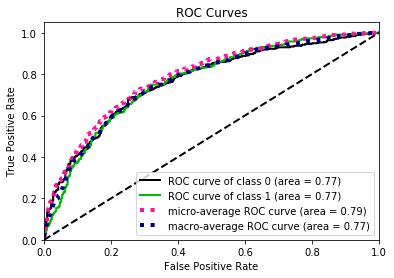

In [116]:
rf.fit(X_train, y_train)

y_true = y_test
y_probas = rf.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

In [117]:
print(metrics.classification_report(y_test,rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       554
           1       0.66      0.50      0.57       331

   micro avg       0.72      0.72      0.72       885
   macro avg       0.70      0.67      0.68       885
weighted avg       0.71      0.72      0.71       885



In [118]:
#from sklearn.tree import export_graphviz
## Export as dot file
#export_graphviz(rf.estimators_[5], out_file='tree.dot', 
#                feature_names = X_test.columns,
#                class_names = ['0', '1'],
#                #rounded = True, proportion = False, 
#                #precision = 2, filled = True
#               )
#
## Convert to png using system command (requires Graphviz)
#from subprocess import call
#call(['/Users/kerrydriscoll/Documents/Spotify_recruiting', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
#
## Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')

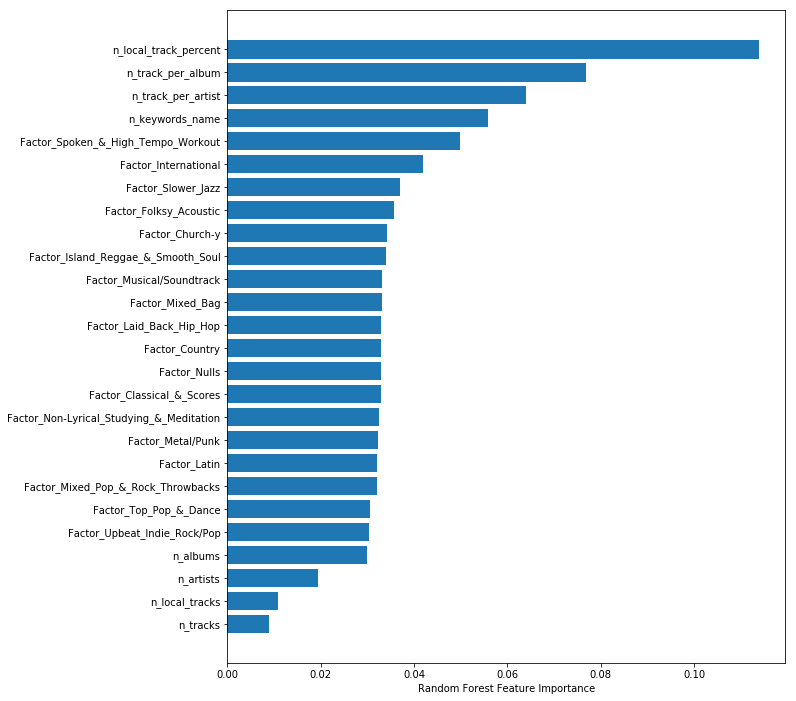

In [119]:
rf.fit(X,y)

fig, ax= plt.subplots(figsize=(10,12))

sorted_idx = rf.feature_importances_.argsort()
ax.barh(X.columns, rf.feature_importances_[sorted_idx])
ax.set_xlabel("Random Forest Feature Importance")
plt.close()
fig

In [120]:
algorithms = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for algo in algorithms:
    score = cross_val_score(linear_model.LogisticRegression(max_iter= 4000, solver= algo, random_state= 101)
                            , X, y, cv= skf, scoring="accuracy")
    print(f'Average score({algo}): {"{:.3f}".format(score.mean())}')


Average score(newton-cg): 0.672
Average score(lbfgs): 0.672
Average score(liblinear): 0.672


/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Average score(sag): 0.669


/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Average score(saga): 0.672


/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



# Additional Meta from API

In [124]:
top10 = df.sort_values(by='mau', ascending=False).head(10)[['playlist_uri','owner',
                                                    'mau','tokens','Dominant Factor'
                                                   ]]
top10['actual_title'] = top10['playlist_uri'].apply(lambda x: get_playlist_name(x))
top10

HTTP Error for GET to https://api.spotify.com/v1/playlists/5FJXhjdILmRA2z5bvz4nzf returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/playlists/3MlpudZs4HT3i0yGPVfmHC returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/playlists/1yHZ5C3penaxRdWR7LRIOb returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/playlists/5yolys8XG4q7YfjYGl5Lff returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/playlists/16BpjqQV1Ey0HeDueNDSYz returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/playlists/4BKT5olNFqLB1FAa8OtC8k returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/playlists/04MJzJlzOoy5bTytJwDsVL returned 404 due to Not found.


playlist_uri    owner      mau  \
152032  spotify:user:spotify:playlist:5FJXhjdILmRA2z5b...  spotify  1944150   
163726  spotify:user:spotify:playlist:4hOKQuZbraPDIfaG...  spotify  1453097   
216752  spotify:user:spotify:playlist:3ZgmfR6lsnCwdffZ...  spotify   688999   
401060  spotify:user:spotify:playlist:3MlpudZs4HT3i0yG...  spotify   430129   
141745  spotify:user:spotify:playlist:1yHZ5C3penaxRdWR...  spotify   352464   
309410  spotify:user:spotify:playlist:5yolys8XG4q7YfjY...  spotify   339484   
228933  spotify:user:spotify:playlist:16BpjqQV1Ey0HeDu...  spotify   326736   
139600  spotify:user:spotify:playlist:4BKT5olNFqLB1FAa...  spotify   307520   
238664  spotify:user:spotify:playlist:4dJHrPYVdKgaCE3L...  spotify   285244   
307283  spotify:user:spotify:playlist:04MJzJlzOoy5bTyt...  spotify   278966   

                                           tokens  \
152032                            ["top", "hits"]   
163726  ["top", "tracks", "currently", "spotify"]   
216752        ["top", "pop", "tracks", "spotify"]   
401060                          ["teen", "party"]   
141745                ["new", "music", "tuesday"]   
309410                 ["hip", "hop", "monsters"]   
228933                  ["afternoon", "acoustic"]   
139600                ["favorite", "coffeehouse"]   
238664      ["top", "indie", "tracks", "spotify"]   
307283                   ["dance", "mega", "mix"]   

                           Dominant Factor  \
152032              Factor_Top_Pop_&_Dance   
163726                    Factor_Mixed_Bag   
216752              Factor_Top_Pop_&_Dance   
401060  Factor_Mixed_Pop_&_Rock_Throwbacks   
141745        Factor_Upbeat_Indie_Rock/Pop   
309410              Factor_Top_Pop_&_Dance   
228933              Factor_Folksy_Acoustic   
139600              Factor_Folksy_Acoustic   
238664  Factor_Mixed_Pop_&_Rock_Throwbacks   
307283              Factor_Top_Pop_&_Dance   

                               actual_title  
152032                                 None  
163726  Top 100 tracks currently on Spotify  
216752        Top 100 Pop Tracks on Spotify  
401060                                 None  
141745                                 None  
309410                                 None  
228933                                 None  
139600                                 None  
238664      Top 100 Indie Tracks on Spotify  
307283                                 None

In [125]:
top10_per_type = df2[df2['owner']!='spotify'].sort_values(by='mau', ascending=False)\
    .groupby('Dominant Factor').head(10).sort_values(by=['Dominant Type',
                                                        'mau']
                                         , ascending=[True, False])[['playlist_uri','tokens',
                                                           'Dominant Factor', 'owner', 'mau']]\
    .reset_index(drop=True)

top10_per_type['actual_title'] = top10_per_type['playlist_uri'].apply(lambda x: get_playlist_name(x))
top10_per_type[170:]

HTTP Error for GET to https://api.spotify.com/v1/playlists/1bNVBDbxwB5sPEW3GJaoSu returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/playlists/7BDa7IEEEbYA1wqz2aR05u returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/playlists/1j4RwY2l1HO65mDButD9uc returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/playlists/7tE7HBDvpNjE8H5YXI3YNp returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/playlists/1VgRf3OQ9rhLyuWzyEDfoi returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/playlists/6PnXc5DfHZMsQhVX5lgL5V returned 404 due to Not found.
HTTP Error for GET to https://api.spotify.com/v1/playlists/2JBq5slxdDy6GDHM0foMDs returned 404 due to Not found.


playlist_uri  \
170  spotify:user:a2e9efe4e9ec6085a112881a50650d51:...   
171  spotify:user:e7b81f7114fe696a958a67c78681abb6:...   
172  spotify:user:52c9c4e80b12d920892f773d75fb04cb:...   
173  spotify:user:e80a283aa98376aa3b632bc8e21c2a7e:...   
174  spotify:user:8f127d412e9d9213e8be59f08a2641cd:...   
175  spotify:user:491a4f24d9e371095364cff4f59981a5:...   
176  spotify:user:f44d2395876db905a928124ea3c00bd3:...   
177  spotify:user:32c29b4c12af78b08b403ed29e42317d:...   
178  spotify:user:a6868acdb07d9768285683154bd4511b:...   
179  spotify:user:c5047c838db867e842a091d8b1c75c6a:...   

                                                tokens  \
170                      ["greatest", "songs", "ever"]   
171                        ["upbeat", "summer", "sun"]   
172                                  ["sexy", "beats"]   
173                       ["hipster", "international"]   
174                                      ["favorites"]   
175                                        ["mixtape"]   
176                             ["hipster", "morning"]   
177                           ["love", "love", "love"]   
178  ["monsters", "door", "cinema", "club", "heart"...   
179                              ["best", "christian"]   

                  Dominant Factor                             owner    mau  \
170  Factor_Upbeat_Indie_Rock/Pop  a2e9efe4e9ec6085a112881a50650d51  36780   
171  Factor_Upbeat_Indie_Rock/Pop  e7b81f7114fe696a958a67c78681abb6  34259   
172  Factor_Upbeat_Indie_Rock/Pop  52c9c4e80b12d920892f773d75fb04cb  25908   
173  Factor_Upbeat_Indie_Rock/Pop  e80a283aa98376aa3b632bc8e21c2a7e  22064   
174  Factor_Upbeat_Indie_Rock/Pop  8f127d412e9d9213e8be59f08a2641cd  16199   
175  Factor_Upbeat_Indie_Rock/Pop  491a4f24d9e371095364cff4f59981a5  13021   
176  Factor_Upbeat_Indie_Rock/Pop  f44d2395876db905a928124ea3c00bd3  12858   
177  Factor_Upbeat_Indie_Rock/Pop  32c29b4c12af78b08b403ed29e42317d  12207   
178  Factor_Upbeat_Indie_Rock/Pop  a6868acdb07d9768285683154bd4511b  11669   
179  Factor_Upbeat_Indie_Rock/Pop  c5047c838db867e842a091d8b1c75c6a  11603   

                                          actual_title  
170                                Greatest songs ever  
171                                Upbeat + Summer Sun  
172                                        Sexy Beats   
173                              Hipster International  
174                                   Beth's favorites  
175                      😍 Your Girlfriend's Mixtape ♫  
176                                    Hipster Morning  
177                                     Love Love Love  
178  Mumford/Lumineers/Of Monsters and Men/Avett Br...  
179                                  Best of Christian

In [126]:
def get_playlist_info(playlist_uri):
    results = sp.playlist(playlist_uri)
    
    name = results['name']
    if len(results['images'])>2:
        img = results['images'][math.floor(len(results['images'])/2)]['url']
    else: 
        img = results['images'][0]['url']
    url = results['external_urls']['spotify']
    owner = results['owner']['display_name']
    track_names_100 = [i['track']['name'] for i in results['tracks']['items']]
    artists_100 = [", ".join([t['name'] for t in i['track']['album']['artists']]) for i in results['tracks']['items']]
    popularity_100 = [i['track']['popularity'] for i in results['tracks']['items']]
    added_at_100 = [i['added_at'] for i in results['tracks']['items']]
    
    playlist_df = pd.DataFrame.from_dict({'name':[name]*len(track_names_100)
                                  ,'url':[url]*len(track_names_100)
                                  ,'snapshot':[img]*len(track_names_100)
                                  ,'owner':[owner]*len(track_names_100)
                                  ,'track':track_names_100
                                  ,'artist':artists_100
                                  ,'popularity':popularity_100
                                  ,'added_at':added_at_100
                                  })
    playlist_df['added_at'] = pd.to_datetime(playlist_df['added_at'])
    return playlist_df


playlist = get_playlist_info(df['playlist_uri'].sample(1).iloc[0])
playlist

name                                                url  \
0   Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
1   Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
2   Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
3   Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
4   Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
5   Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
6   Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
7   Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
8   Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
9   Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
10  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
11  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
12  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
13  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
14  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
15  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
16  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
17  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
18  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
19  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
20  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
21  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
22  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
23  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
24  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
25  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
26  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
27  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
28  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
29  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
30  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   
31  Kany Garcia  https://open.spotify.com/playlist/0xdHcvs8ZMEL...   

                                             snapshot               owner  \
0   https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
1   https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
2   https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
3   https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
4   https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
5   https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
6   https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
7   https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
8   https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
9   https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
10  https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
11  https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
12  https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
13  https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
14  https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
15  https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
16  https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
17  https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
18  https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
19  https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
20  https://mosaic.scdn.co/300/ab67616d0000b273134...  Lynda Laverde-Pozo   
21  ht

In [127]:
trappin = 'spotify:user:299c8503c71e80bacedebc6c9c958c96:playlist:70dsG1zb80yzdI0B9yvvW1'
playlist = get_playlist_info(trappin)
playlist

name                                                url  \
0   Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
1   Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
2   Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
3   Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
4   Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
5   Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
6   Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
7   Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
8   Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
9   Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
10  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
11  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
12  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
13  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
14  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
15  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
16  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
17  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
18  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
19  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
20  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
21  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
22  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
23  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
24  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
25  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
26  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
27  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
28  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
29  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
..                   ...                                                ...   
70  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
71  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
72  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
73  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
74  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
75  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
76  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
77  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
78  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
79  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
80  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
81  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
82  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
83  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
84  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
85  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
86  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
87  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80yz...   
88  Trappin Down Coastal  https://open.spotify.com/playlist/70dsG1zb80

In [128]:
playlist['url'][0]

'https://open.spotify.com/playlist/70dsG1zb80yzdI0B9yvvW1'

In [129]:
Image(url=playlist['snapshot'][0])

In [130]:
skydiving = 'spotify:user:a3a6b2ae90f8974950f7793ff3a743e0:playlist:7d8DfJHRfZpFhcauFCckAy'
playlist = get_playlist_info(skydiving)
playlist

name                                                url  \
0   Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
1   Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
2   Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
3   Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
4   Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
5   Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
6   Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
7   Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
8   Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
9   Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
10  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
11  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
12  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
13  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
14  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
15  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
16  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
17  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
18  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
19  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
20  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
21  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
22  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
23  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
24  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
25  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
26  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
27  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
28  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
29  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
30  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
31  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
32  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
33  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
34  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
35  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
36  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
37  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
38  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
39  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
40  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
41  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
42  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
43  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
44  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
45  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
46  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
47  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
48  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
49  Songs for Skydiving  https://open.spotify.com/playlist/7d8DfJHRfZpF...   
50  Songs for Skydiving  https://open.spo

In [131]:
Image(url=playlist['snapshot'][0])

In [132]:
#'spotify:user:spotify:playlist:2lDJ2xtmpCSN9CO7ZBkIVc'
alpha = 'spotify:user:3b6780bff55ea8610171ce447d01dbc6:playlist:4KFzuzisGGTzzvtdauGsTj'
playlist = get_playlist_info(alpha)
playlist

name                                                url  \
0   alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
1   alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
2   alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
3   alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
4   alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
5   alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
6   alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
7   alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
8   alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
9   alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
10  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
11  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
12  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
13  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
14  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
15  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
16  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
17  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
18  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
19  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
20  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
21  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
22  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
23  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
24  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
25  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
26  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
27  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
28  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
29  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
..              ...                                                ...   
32  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
33  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
34  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
35  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
36  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
37  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
38  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
39  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
40  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
41  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
42  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
43  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
44  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
45  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
46  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
47  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
48  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
49  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
50  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
51  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
52  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
53  alpha and omega  https://open.spotify.com/playlist/4KFzuzisGGTz...   
54  alpha and omega

In [133]:
Image(url=playlist['snapshot'][0])

In [134]:
metal = 'spotify:user:828547771295e2d48a1c926f7f01e815:playlist:1K2FqBKRL7uH59Ff8voHW4'
playlist = get_playlist_info(metal)
playlist

name  \
0   Might and Myth: Power Metal   
1   Might and Myth: Power Metal   
2   Might and Myth: Power Metal   
3   Might and Myth: Power Metal   
4   Might and Myth: Power Metal   
5   Might and Myth: Power Metal   
6   Might and Myth: Power Metal   
7   Might and Myth: Power Metal   
8   Might and Myth: Power Metal   
9   Might and Myth: Power Metal   
10  Might and Myth: Power Metal   
11  Might and Myth: Power Metal   
12  Might and Myth: Power Metal   
13  Might and Myth: Power Metal   
14  Might and Myth: Power Metal   
15  Might and Myth: Power Metal   
16  Might and Myth: Power Metal   
17  Might and Myth: Power Metal   
18  Might and Myth: Power Metal   
19  Might and Myth: Power Metal   
20  Might and Myth: Power Metal   
21  Might and Myth: Power Metal   
22  Might and Myth: Power Metal   
23  Might and Myth: Power Metal   
24  Might and Myth: Power Metal   
25  Might and Myth: Power Metal   
26  Might and Myth: Power Metal   
27  Might and Myth: Power Metal   
28  Might and Myth: Power Metal   
29  Might and Myth: Power Metal   
..                          ...   
54  Might and Myth: Power Metal   
55  Might and Myth: Power Metal   
56  Might and Myth: Power Metal   
57  Might and Myth: Power Metal   
58  Might and Myth: Power Metal   
59  Might and Myth: Power Metal   
60  Might and Myth: Power Metal   
61  Might and Myth: Power Metal   
62  Might and Myth: Power Metal   
63  Might and Myth: Power Metal   
64  Might and Myth: Power Metal   
65  Might and Myth: Power Metal   
66  Might and Myth: Power Metal   
67  Might and Myth: Power Metal   
68  Might and Myth: Power Metal   
69  Might and Myth: Power Metal   
70  Might and Myth: Power Metal   
71  Might and Myth: Power Metal   
72  Might and Myth: Power Metal   
73  Might and Myth: Power Metal   
74  Might and Myth: Power Metal   
75  Might and Myth: Power Metal   
76  Might and Myth: Power Metal   
77  Might and Myth: Power Metal   
78  Might and Myth: Power Metal   
79  Might and Myth: Power Metal   
80  Might and Myth: Power Metal   
81  Might and Myth: Power Metal   
82  Might and Myth: Power Metal   
83  Might and Myth: Power Metal   

                                                  url  \
0   https://open.spotify.com/playlist/1K2FqBKRL7uH...   
1   https://open.spotify.com/playlist/1K2FqBKRL7uH...   
2   https://open.spotify.com/playlist/1K2FqBKRL7uH...   
3   https://open.spotify.com/playlist/1K2FqBKRL7uH...   
4   https://open.spotify.com/playlist/1K2FqBKRL7uH...   
5   https://open.spotify.com/playlist/1K2FqBKRL7uH...   
6   https://open.spotify.com/playlist/1K2FqBKRL7uH...   
7   https://open.spotify.com/playlist/1K2FqBKRL7uH...   
8   https://open.spotify.com/playlist/1K2FqBKRL7uH...   
9   https://open.spotify.com/playlist/1K2FqBKRL7uH...   
10  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
11  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
12  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
13  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
14  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
15  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
16  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
17  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
18  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
19  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
20  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
21  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
22  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
23  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
24  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
25  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
26  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
27  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
28  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
29  https://open.spotify.com/playlist/1K2FqBKRL7uH...   
..                                                ...   
54  https://open.spotify.com/pla

In [135]:
Image(url=playlist['snapshot'][0])

In [136]:
p4k1 = 'spotify:user:55728914d52d1811b79fc85314351ece:playlist:3aFEJTspALTMAYJmwfEetN'
playlist = get_playlist_info(p4k1)
playlist

name  \
0   Pitchfork Top Songs of the 2010s   
1   Pitchfork Top Songs of the 2010s   
2   Pitchfork Top Songs of the 2010s   
3   Pitchfork Top Songs of the 2010s   
4   Pitchfork Top Songs of the 2010s   
5   Pitchfork Top Songs of the 2010s   
6   Pitchfork Top Songs of the 2010s   
7   Pitchfork Top Songs of the 2010s   
8   Pitchfork Top Songs of the 2010s   
9   Pitchfork Top Songs of the 2010s   
10  Pitchfork Top Songs of the 2010s   
11  Pitchfork Top Songs of the 2010s   
12  Pitchfork Top Songs of the 2010s   
13  Pitchfork Top Songs of the 2010s   
14  Pitchfork Top Songs of the 2010s   
15  Pitchfork Top Songs of the 2010s   
16  Pitchfork Top Songs of the 2010s   
17  Pitchfork Top Songs of the 2010s   
18  Pitchfork Top Songs of the 2010s   
19  Pitchfork Top Songs of the 2010s   
20  Pitchfork Top Songs of the 2010s   
21  Pitchfork Top Songs of the 2010s   
22  Pitchfork Top Songs of the 2010s   
23  Pitchfork Top Songs of the 2010s   
24  Pitchfork Top Songs of the 2010s   
25  Pitchfork Top Songs of the 2010s   
26  Pitchfork Top Songs of the 2010s   
27  Pitchfork Top Songs of the 2010s   
28  Pitchfork Top Songs of the 2010s   
29  Pitchfork Top Songs of the 2010s   
..                               ...   
70  Pitchfork Top Songs of the 2010s   
71  Pitchfork Top Songs of the 2010s   
72  Pitchfork Top Songs of the 2010s   
73  Pitchfork Top Songs of the 2010s   
74  Pitchfork Top Songs of the 2010s   
75  Pitchfork Top Songs of the 2010s   
76  Pitchfork Top Songs of the 2010s   
77  Pitchfork Top Songs of the 2010s   
78  Pitchfork Top Songs of the 2010s   
79  Pitchfork Top Songs of the 2010s   
80  Pitchfork Top Songs of the 2010s   
81  Pitchfork Top Songs of the 2010s   
82  Pitchfork Top Songs of the 2010s   
83  Pitchfork Top Songs of the 2010s   
84  Pitchfork Top Songs of the 2010s   
85  Pitchfork Top Songs of the 2010s   
86  Pitchfork Top Songs of the 2010s   
87  Pitchfork Top Songs of the 2010s   
88  Pitchfork Top Songs of the 2010s   
89  Pitchfork Top Songs of the 2010s   
90  Pitchfork Top Songs of the 2010s   
91  Pitchfork Top Songs of the 2010s   
92  Pitchfork Top Songs of the 2010s   
93  Pitchfork Top Songs of the 2010s   
94  Pitchfork Top Songs of the 2010s   
95  Pitchfork Top Songs of the 2010s   
96  Pitchfork Top Songs of the 2010s   
97  Pitchfork Top Songs of the 2010s   
98  Pitchfork Top Songs of the 2010s   
99  Pitchfork Top Songs of the 2010s   

                                                  url  \
0   https://open.spotify.com/playlist/3aFEJTspALTM...   
1   https://open.spotify.com/playlist/3aFEJTspALTM...   
2   https://open.spotify.com/playlist/3aFEJTspALTM...   
3   https://open.spotify.com/playlist/3aFEJTspALTM...   
4   https://open.spotify.com/playlist/3aFEJTspALTM...   
5   https://open.spotify.com/playlist/3aFEJTspALTM...   
6   https://open.spotify.com/playlist/3aFEJTspALTM...   
7   https://open.spotify.com/playlist/3aFEJTspALTM...   
8   https://open.spotify.com/playlist/3aFEJTspALTM...   
9   https://open.spotify.com/playlist/3aFEJTspALTM...   
10  https://open.spotify.com/playlist/3aFEJTspALTM...   
11  https://open.spotify.com/playlist/3aFEJTspALTM...   
12  https://open.spotify.com/playlist/3aFEJTspALTM...   
13  https://open.spotify.com/playlist/3aFEJTspALTM...   
14  https://open.spotify.com/playlist/3aFEJTspALTM...   
15  https://open.spotify.com/playlist/3aFEJTspALTM...   
16  https://open.spotify.com/playlist/3aFEJTspALTM...   
17  https://open.spotify.com/playlist/3aFEJTspALTM...   
18  https://open.spotify.com/playlist/3aFEJTspALTM...   
19  https://open.spotify.com/playlist/3aFEJTspALTM...   
20  https://open.spotify.com/playlist/3aFEJTspALTM...   
21  https://open.spotify.com/playlist/3aFEJTspALTM...   
22  https://open.spotify.com/playlist/3aFEJTspALTM...   
23  https://open.spotify.com/playlist/3aFEJTspALTM...   
24  https://open.spotify.com/playlist/3aFEJTspALTM...   
25  https://open.spotify.com/playlist/3aFEJTspALTM...   
26  https://

In [137]:
Image(url=playlist['snapshot'][0])

In [138]:
kcrw = 'spotify:user:f51ba2d719b159998e8e6c37e08aff7c:playlist:2udv9AERTo3Um2WIPZpwBi'
playlist = get_playlist_info(kcrw)
playlist

name                                                url  \
0   KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
1   KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
2   KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
3   KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
4   KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
5   KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
6   KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
7   KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
8   KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
9   KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
10  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
11  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
12  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
13  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
14  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
15  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
16  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
17  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
18  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
19  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
20  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
21  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
22  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
23  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
24  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
25  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
26  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
27  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
28  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
29  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
..                ...                                                ...   
70  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
71  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
72  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
73  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
74  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
75  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
76  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
77  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
78  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
79  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
80  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
81  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
82  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
83  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
84  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
85  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
86  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
87  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
88  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
89  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AERTo3U...   
90  KCRW's Top Tracks  https://open.spotify.com/playlist/2udv9AER

In [139]:
Image(url=playlist['snapshot'][0])

In [140]:
dallas = 'spotify:user:81040c29889757293fba9b7ccbd493a6:playlist:4Zm7yQw2WR23v4Ay58JeoX'
playlist = get_playlist_info(dallas)
playlist

name  \
0   Dallas Stars Arena Playlist 2013-19   
1   Dallas Stars Arena Playlist 2013-19   
2   Dallas Stars Arena Playlist 2013-19   
3   Dallas Stars Arena Playlist 2013-19   
4   Dallas Stars Arena Playlist 2013-19   
5   Dallas Stars Arena Playlist 2013-19   
6   Dallas Stars Arena Playlist 2013-19   
7   Dallas Stars Arena Playlist 2013-19   
8   Dallas Stars Arena Playlist 2013-19   
9   Dallas Stars Arena Playlist 2013-19   
10  Dallas Stars Arena Playlist 2013-19   
11  Dallas Stars Arena Playlist 2013-19   
12  Dallas Stars Arena Playlist 2013-19   
13  Dallas Stars Arena Playlist 2013-19   
14  Dallas Stars Arena Playlist 2013-19   
15  Dallas Stars Arena Playlist 2013-19   
16  Dallas Stars Arena Playlist 2013-19   
17  Dallas Stars Arena Playlist 2013-19   
18  Dallas Stars Arena Playlist 2013-19   
19  Dallas Stars Arena Playlist 2013-19   
20  Dallas Stars Arena Playlist 2013-19   
21  Dallas Stars Arena Playlist 2013-19   
22  Dallas Stars Arena Playlist 2013-19   
23  Dallas Stars Arena Playlist 2013-19   
24  Dallas Stars Arena Playlist 2013-19   
25  Dallas Stars Arena Playlist 2013-19   
26  Dallas Stars Arena Playlist 2013-19   
27  Dallas Stars Arena Playlist 2013-19   
28  Dallas Stars Arena Playlist 2013-19   
29  Dallas Stars Arena Playlist 2013-19   
..                                  ...   
70  Dallas Stars Arena Playlist 2013-19   
71  Dallas Stars Arena Playlist 2013-19   
72  Dallas Stars Arena Playlist 2013-19   
73  Dallas Stars Arena Playlist 2013-19   
74  Dallas Stars Arena Playlist 2013-19   
75  Dallas Stars Arena Playlist 2013-19   
76  Dallas Stars Arena Playlist 2013-19   
77  Dallas Stars Arena Playlist 2013-19   
78  Dallas Stars Arena Playlist 2013-19   
79  Dallas Stars Arena Playlist 2013-19   
80  Dallas Stars Arena Playlist 2013-19   
81  Dallas Stars Arena Playlist 2013-19   
82  Dallas Stars Arena Playlist 2013-19   
83  Dallas Stars Arena Playlist 2013-19   
84  Dallas Stars Arena Playlist 2013-19   
85  Dallas Stars Arena Playlist 2013-19   
86  Dallas Stars Arena Playlist 2013-19   
87  Dallas Stars Arena Playlist 2013-19   
88  Dallas Stars Arena Playlist 2013-19   
89  Dallas Stars Arena Playlist 2013-19   
90  Dallas Stars Arena Playlist 2013-19   
91  Dallas Stars Arena Playlist 2013-19   
92  Dallas Stars Arena Playlist 2013-19   
93  Dallas Stars Arena Playlist 2013-19   
94  Dallas Stars Arena Playlist 2013-19   
95  Dallas Stars Arena Playlist 2013-19   
96  Dallas Stars Arena Playlist 2013-19   
97  Dallas Stars Arena Playlist 2013-19   
98  Dallas Stars Arena Playlist 2013-19   
99  Dallas Stars Arena Playlist 2013-19   

                                                  url  \
0   https://open.spotify.com/playlist/4Zm7yQw2WR23...   
1   https://open.spotify.com/playlist/4Zm7yQw2WR23...   
2   https://open.spotify.com/playlist/4Zm7yQw2WR23...   
3   https://open.spotify.com/playlist/4Zm7yQw2WR23...   
4   https://open.spotify.com/playlist/4Zm7yQw2WR23...   
5   https://open.spotify.com/playlist/4Zm7yQw2WR23...   
6   https://open.spotify.com/playlist/4Zm7yQw2WR23...   
7   https://open.spotify.com/playlist/4Zm7yQw2WR23...   
8   https://open.spotify.com/playlist/4Zm7yQw2WR23...   
9   https://open.spotify.com/playlist/4Zm7yQw2WR23...   
10  https://open.spotify.com/playlist/4Zm7yQw2WR23...   
11  https://open.spotify.com/playlist/4Zm7yQw2WR23...   
12  https://open.spotify.com/playlist/4Zm7yQw2WR23...   
13  https://open.spotify.com/playlist/4Zm7yQw2WR23...   
14  https://open.spotify.com/playlist/4Zm7yQw2WR23...   
15  https://open.spotify.com/playlist/4Zm7yQw2WR23...   
16  https://open.spotify.com/playlist/4Zm7yQw2WR23...   
17  https://open.spotify.com/playlist/4Zm7yQw2WR23...   
18  https://open.spotify.com/playlist/4Zm7yQw2WR23...   
19  https://open.spotify.com/playlist/4Zm7yQw2WR23...   
20  https://open.spotify.com/playlist/4Zm7yQw2WR23...   
21  https://open.spotify.com/playlist/4Zm7yQw2WR23...   
22  https://open.spotify.com/playlist/4Zm7yQw2WR23...   


In [141]:
Image(url=playlist['snapshot'][0])

In [142]:
riot = 'spotify:user:1b9da265027bd2050c72b9aeee3bac9c:playlist:3knW3GvMr03uMNpX5KmgUK'
playlist = get_playlist_info(riot)
playlist

name                                                url  \
0   Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
1   Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
2   Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
3   Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
4   Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
5   Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
6   Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
7   Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
8   Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
9   Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
10  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
11  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
12  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
13  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
14  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
15  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
16  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
17  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
18  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
19  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
20  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
21  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
22  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
23  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
24  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
25  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
26  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
27  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
28  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
29  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
..                    ...                                                ...   
70  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
71  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
72  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
73  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
74  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
75  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
76  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
77  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
78  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
79  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
80  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
81  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
82  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
83  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
84  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
85  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
86  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
87  Riotfest 2014 Chicago  https://open.spotify.com/playlist/3knW3GvMr03u...   
88  Riotfest 2014 Chi

In [143]:
Image(url=playlist['snapshot'][0])

In [144]:
#spotify:user:c3b78c1e29e618effcf03a0b0e50be17:playlist:0bo6cIuYYEAznIzJjVpBjW
josh = 'spotify:user:c3b78c1e29e618effcf03a0b0e50be17:playlist:0bo6cIuYYEAznIzJjVpBjW'
playlist = get_playlist_info(josh)
playlist

name                                                url  \
0   JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
1   JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
2   JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
3   JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
4   JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
5   JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
6   JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
7   JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
8   JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
9   JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
10  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
11  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
12  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
13  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
14  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
15  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
16  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
17  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
18  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
19  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
20  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
21  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
22  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
23  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
24  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
25  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
26  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
27  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
28  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
29  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
..     ...                                                ...   
70  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
71  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
72  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
73  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
74  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
75  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
76  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
77  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
78  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
79  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
80  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
81  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
82  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
83  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
84  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
85  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
86  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
87  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
88  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
89  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
90  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
91  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
92  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
93  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
94  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
95  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
96  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
97  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
98  JoshOG  https://open.spotify.com/playlist/0bo6cIuYYEAz...   
99  JoshOG  https://open.spotify.com/play

In [145]:
Image(url=playlist['snapshot'][0])

In [146]:
study = 'spotify:user:7dfec6d119da5a0083d2b67070af8d15:playlist:33oYAKEYb5nKQ55j9VZZna'
playlist = get_playlist_info(study)
playlist

name                                                url  \
0   epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
1   epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
2   epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
3   epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
4   epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
5   epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
6   epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
7   epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
8   epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
9   epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
10  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
11  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
12  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
13  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
14  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
15  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
16  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
17  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
18  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
19  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
20  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
21  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
22  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
23  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
24  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
25  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
26  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
27  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
28  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
29  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
..               ...                                                ...   
70  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
71  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
72  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
73  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
74  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
75  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
76  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
77  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
78  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
79  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
80  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
81  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
82  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
83  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
84  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
85  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
86  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
87  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
88  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
89  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
90  epic study music  https://open.spotify.com/playlist/33oYAKEYb5nK...   
91  epic study music  https://open.spotif

In [147]:
Image(url=playlist['snapshot'][0])